In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_circles, make_regression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse, accuracy_score

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

1. В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_features=2, n_informative=2, 
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

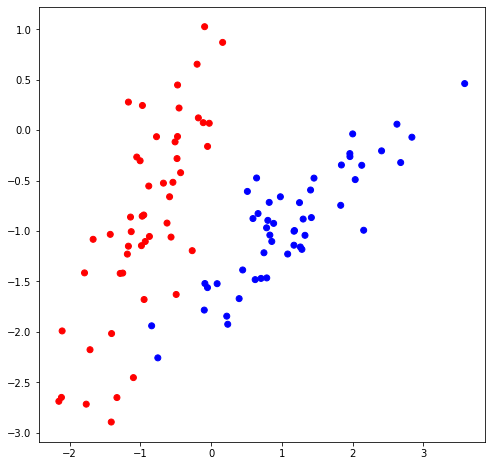

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)
# т.е. это то место где мы останавливаем вычисления и назначаем прогноз
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data              # это матрица признаков
        self.labels = labels          # это истинные ответы
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов" - склько раз каждый класс встретился в листе
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

$$H(X) = \sum^{K}_{k=1}p_{k}(1-p_{k}) = 1 - \sum_{k=1}^K{p_k^2} ,$$


In [6]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)  # для каждого класса считаем какую доль он составляет относительно всей выборки
        impurity -= p ** 2
        
    return impurity

$$H(X_{m}) - \frac{|X_{l}|}{|X_{m}|}H(X_{l}) - \frac{|X_{r}|}{|X_{m}|}H(X_{r}),$$


In [7]:
# Расчет прироста

def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    # root_gini - gini на предыдущей итерации
    # gini - gini для левой и правой подвыборок
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    # синтаксис where(условие, что вернуть если условие выполняется, что вернуть если нет)
    # здесь только условие, поэтому мы просто хотим получить маски верно условие или нет
    # поэтому здесь where возвращает True или False
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    # выбираем те лейблы и те обекты для которых сработало условие
    # и которые мы отправляем в левое поддерево и в правое поддерево
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения
# функция перебирает все признаки и все пороги и ищет наиболее оптимальное разбиение
# data - матрица признаков, labels - лейблы
def find_best_split(data, labels, min_samples_leaf, n_features):
    
    #  обозначим минимальное количество объектов в узле
    # min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    # количество признаков по которым проходимся в цикле
    # n_features = data.shape[1]
    
    # цикл перебора по признакам
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        # перебор по всем уникальным значениям признака
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов.
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции (не лучшее решение но для учебных целей пойдёт)

def build_tree(data, labels, min_samples_leaf, n_features):

    gain, t, index = find_best_split(data, labels, min_samples_leaf, n_features)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, min_samples_leaf, n_features)
    false_branch = build_tree(false_data, false_labels, min_samples_leaf, n_features)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
# функция классификации объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data, 
                                                                    classification_labels, 
                                                                    test_size=0.3,
                                                                    random_state=1)

In [14]:
# Построим дерево по обучающей выборке

# ограничение по минимальному количеству объектов в листе
min_samples_leaf = 5

# ограничение по количеству признаков для обучения
n_features = 2

my_tree = build_tree(train_data, train_labels, min_samples_leaf, n_features)

In [15]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.16261402870113306
--> True:
  Индекс 1 <= -1.5208896621663803
  --> True:
    Индекс 0 <= -0.9478301462477035
    --> True:
      Прогноз: 0
    --> False:
      Прогноз: 1
  --> False:
    Прогноз: 0
--> False:
  Прогноз: 1


In [16]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [17]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [19]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

98.57142857142858

In [20]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

100.0

In [21]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_data, test_data):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

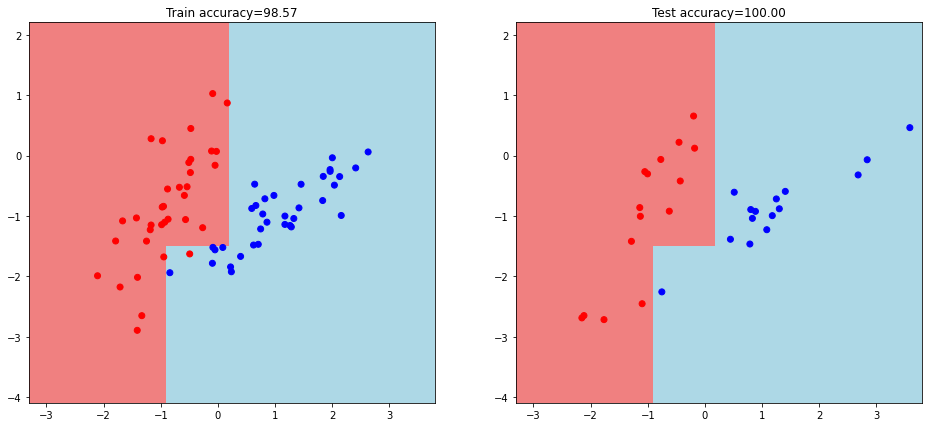

In [22]:
visualize(train_data, test_data)

2. *Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [23]:
# сгенерируем данные
# sklearn.datasets.make_regression(n_samples=100, n_features=100, *, n_informative=10, n_targets=1, bias=0.0, 
#     effective_rank=None, tail_strength=0.5, noise=0.0, shuffle=True, coef=False, random_state=None)[source]
X, y = make_regression(n_features=1, n_informative=2, noise = 5, random_state=5)
#plt.figure(figsize=(8,8))
#plt.scatter(X, y);

In [24]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [25]:
# И класс терминального узла (листа)
# т.е. это то место где мы останавливаем вычисления и назанчаем прогноз
class Leaf:
    
    def __init__(self, data, y_true):
        self.data = data              # это матрица признаков
        self.y_true = y_true         # это истинные ответы
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
#         classes = {}  # сформируем словарь "класс: количество объектов" - склько раз каждый класс встретился в листе
#         for label in self.labels:
#             if label not in classes:
#                 classes[label] = 0
#             classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        # prediction = max(classes, key=classes.get)
        prediction = np.mean(self.y_true)
        return prediction        

In [26]:
def mse(array):
    mean = array.mean()
    return np.mean((array - mean)**2)

In [27]:
# Расчет прироста

def gain(left_labels, right_labels, root_mse):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    # root_gini - gini на предыдущей итерации
    # gini - gini для левой и правой подвыборок
    return root_mse - p * mse(left_labels) - (1 - p) * mse(right_labels)

In [28]:
# Разбиение датасета в узле

def split(data, labels, column_index, t):
    # синтаксис where(условие, что вернуть если условие выполняется, что вернуть если нет)
    # здесь только условие, поэтому мы просто хотим получить маски верно условие или нет
    # поэтому здесь where возвращает True или False
    left = np.where(data[:, column_index] <= t)
    right = np.where(data[:, column_index] > t)
    
    # выбираем те лейблы и те обекты для которых сработало условие
    # и которые мы отправляем в левое поддерево и в правое поддерево
    true_data = data[left]
    false_data = data[right]
    
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [29]:
# Нахождение наилучшего разбиения
# функция перебирает все признаки и все пороги и ищет наиболее оптимальное разбиение
# data - матрица признаков, labels - лейблы
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_mse = mse(labels)

    best_gain = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # цикл перебора по признакам
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        # перебор по всем уникальным значениям признака
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue
            
            current_gain = gain(true_labels, false_labels, root_mse)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [30]:
# Построение дерева с помощью рекурсивной функции (не лучшее решение но для учебных целей пойдёт)

def build_tree(data, labels):

    gain, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [31]:
# функция классификации объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [32]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [33]:
# Разобьем выборку на обучающую и тестовую

from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

In [34]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_X, train_y)

In [35]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0 <= 0.34691932708774675
--> True:
  Индекс 0 <= -1.164701910115395
  --> True:
    Прогноз: -96.30007283479536
  --> False:
    Индекс 0 <= -0.3058530211666308
    --> True:
      Индекс 0 <= -0.5916366579302884
      --> True:
        Индекс 0 <= -0.7104664469959762
        --> True:
          Прогноз: -41.72319622077178
        --> False:
          Прогноз: -37.31454390056709
      --> False:
        Индекс 0 <= -0.42703138590481854
        --> True:
          Прогноз: -24.17921652696336
        --> False:
          Прогноз: -23.251450445433658
    --> False:
      Индекс 0 <= 0.012758316706164157
      --> True:
        Индекс 0 <= -0.10061434630710828
        --> True:
          Прогноз: -9.610913503258395
        --> False:
          Прогноз: -0.07859135401524195
      --> False:
        Прогноз: 11.006835348491457
--> False:
  Индекс 0 <= 1.189060725824544
  --> True:
    Индекс 0 <= 0.7930533194619698
    --> True:
      Индекс 0 <= 0.6034716026094954
      --> True:
   

In [36]:
# Получим ответы для обучающей выборки 
train_y_pred = predict(train_X, my_tree)

In [37]:
# И получим ответы для тестовой выборки
test_y_pred = predict(test_X, my_tree)

In [38]:
# R2
print(f'R2 train = {r2(train_y, train_y_pred).round(3)}')
print(f'R2 test = {r2(test_y, test_y_pred).round(3)}')

R2 train = 0.949
R2 test = 0.903


<Figure size 432x288 with 0 Axes>

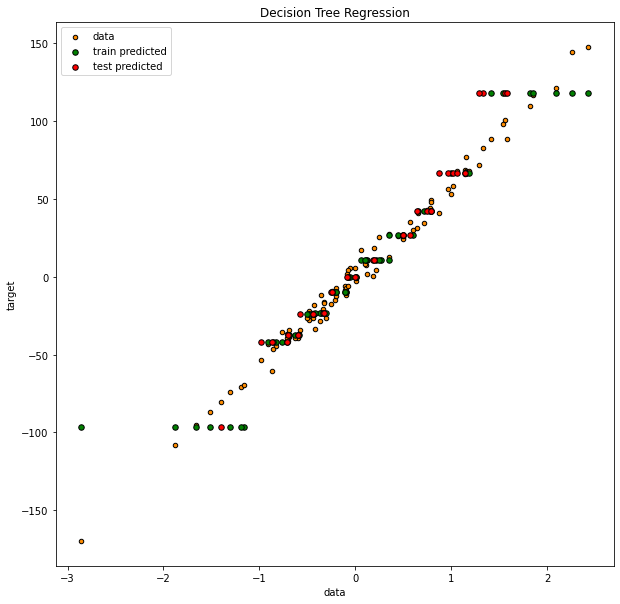

In [39]:
# Plot the results
plt.figure()
plt.figure(figsize=(10,10))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.scatter(train_X, train_y_pred, s=30, edgecolor="black", c="green", label="train predicted")
plt.scatter(test_X, test_y_pred, s=30, edgecolor="black", c="red", label="test predicted")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show();

---
Проверка с использованием scikit-learn

In [40]:
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(train_X, train_y)
test_y_pred = regr.predict(test_X)
train_y_pred = regr.predict(train_X)

In [41]:
print(f'R2 train = {r2(train_y, train_y_pred).round(3)}')
print(f'R2 test = {r2(test_y, test_y_pred).round(3)}')

R2 train = 0.97
R2 test = 0.94


<Figure size 432x288 with 0 Axes>

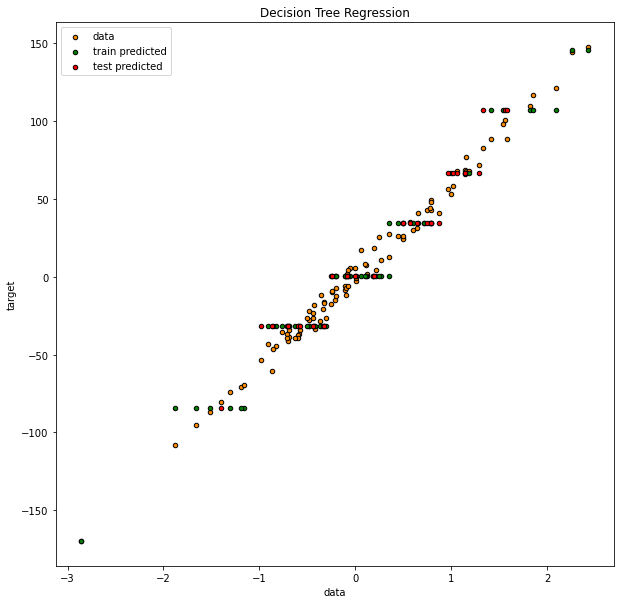

In [42]:
# Plot the results
plt.figure()
plt.figure(figsize=(10,10))
plt.scatter(X, y, s=20, edgecolor="black", c="darkorange", label="data")
plt.scatter(train_X, train_y_pred, s=20, edgecolor="black", c="green", label="train predicted")
plt.scatter(test_X, test_y_pred, s=20, edgecolor="black", c="red", label="test predicted")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show();

Проект: 
1. https://www.kaggle.com/c/regression-tutors-expected-math-exam-results регрессия
1. https://www.kaggle.com/c/classification-choose-tutors классификация